In [36]:
# %%time
# Python 2.7

%matplotlib nbagg
%matplotlib inline 

import sys
sys.path.append('..')
print(sys.version)

import os
import cPickle 
import scipy.io
import numpy as np
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import lasagne 
import lasagne.layers as L
import parmesan
import cPickle as pickle

from sklearn.utils import shuffle

import tools as tls
from data_loaders import svhn



2.7.12 |Continuum Analytics, Inc.| (default, Jun 29 2016, 11:07:13) [MSC v.1500 64 bit (AMD64)]


In [37]:
### GLOBAL PARAMETERS ###
plot_train   = True
using_shared = False

### META - HOW THE PROGRAM WORKS
file_name = 'data_no_share_c3' # assumes '.pkl'

np.random.seed(1234) # reproducibility


### CONSTANTS
dataset = 'MNIST'
print('dataset = {}'.format(dataset))

if dataset == 'SVHN':    
    IMG_LEN = 32
    IMG_DEPTH = 3
    cmap = None
elif dataset == 'MNIST':
    IMG_LEN = 28
    IMG_DEPTH = 1
    cmap = 'gray'
    


dataset = MNIST


In [38]:
### PLOT SETTINGS

plt.rcParams["figure.figsize"] = (8,5)
font_size = 15
plt.rc('font',   size=font_size)       # controls default text sizes
plt.rc('axes',   titlesize=font_size)  # fontsize of the axes title
plt.rc('axes',   labelsize=font_size)  # fontsize of the x any y labels
plt.rc('xtick',  labelsize=font_size)  # fontsize of the tick labels
plt.rc('ytick',  labelsize=font_size)  # fontsize of the tick labels
plt.rc('legend', fontsize=font_size)   # legend fontsize
plt.rc('figure', titlesize=font_size)  # # size of the figure title


In [39]:
%%time
### LOAD DATA

if dataset == 'SVHN':
    full_path = os.path.join(os.getcwd(), 'data')
    full_path = os.path.join(full_path, file_name)
    full_path  += '.pkl'
    print(full_path)

    with open(full_path, 'rb') as f:
        x_trai, t_trai, x_vali, t_vali, x_test, t_test = pickle.load(f)

    x_trai = x_trai/255
    x_vali = x_vali/255
    x_test = x_test/255


elif dataset == 'MNIST':
    full_path = os.path.join(os.getcwd(), 'data')
    full_path = os.path.join(full_path  , 'mnist.npz')

    data = np.load(full_path)
    num_classes = 10
    x_trai = data['X_train'].astype('float32')
    t_trai = data['y_train'].astype('int32')

    x_vali = data['X_valid'].astype('float32')
    t_vali = data['y_valid'].astype('int32')

    x_test = data['X_test'].astype('float32')
    t_test = data['y_test'].astype('int32')


    t_trai = tls.onehot(t_trai, 10)
    t_vali = tls.onehot(t_vali, 10)
    t_test = tls.onehot(t_test, 10)

    
    
print('Size of total dataset: {:.2f} MB'.format(
        (
              sys.getsizeof(x_trai)
            + sys.getsizeof(t_trai)
            + sys.getsizeof(x_vali)
            + sys.getsizeof(t_vali)
            + sys.getsizeof(x_test)
            + sys.getsizeof(t_test)
        )/1.0e6))


Size of total dataset: 225.12 MB
Wall time: 885 ms


In [40]:
### CHECK DATA
num_classes = np.unique(np.where(t_trai == 1)[1]).shape[0]
print('Number of classes {}'.format(num_classes))

num_features = x_trai[0].shape[0]
print('Number of features {}'.format(num_features))

print('')
print('Train shape: ', 
      x_trai.shape, t_trai.shape)

print('Valid shape: ', 
      x_vali.shape, t_vali.shape)

print('Test shape:  ', 
      x_test.shape, t_test.shape)

print('{}'.format(type(x_trai)))
print('{}'.format(type(x_vali)))
print('{}'.format(type(x_test)))
print('')

print('Prior')
print(np.sum(t_trai, axis=0)/t_trai.shape[0])
print(np.sum(t_test, axis=0)/t_test.shape[0])




Number of classes 10
Number of features 784

('Train shape: ', (50000L, 784L), (50000L, 10L))
('Valid shape: ', (10000L, 784L), (10000L, 10L))
('Test shape:  ', (10000L, 784L), (10000L, 10L))
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>

Prior
[ 0.09864  0.11356  0.09936  0.10202  0.09718  0.09012  0.09902  0.1035
  0.09684  0.09976]
[ 0.098   0.1135  0.1032  0.101   0.0982  0.0892  0.0958  0.1028  0.0974
  0.1009]


In [43]:
### Ensure that we have one hot encoding, and that the 
print(t_vali[:10,:])
print(np.where(t_trai == 1)[1][:10])

# If you don't get a 10xNUM_CLASS matrix, and a list with the index of the 1 of
# each row, something went wrong.


### Ensure that the data is scalled appropriately (between 0 and 1)

print('\nMaximum training value: '.format(np.max(x_trai)))
if np.max(x_trai) > 1:
    print('WARNING!! Maximum value in input data is {}'.format(np.max(x_trai)))

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]
[5 0 4 1 9 2 1 3 1 4]

Maximum training value: 


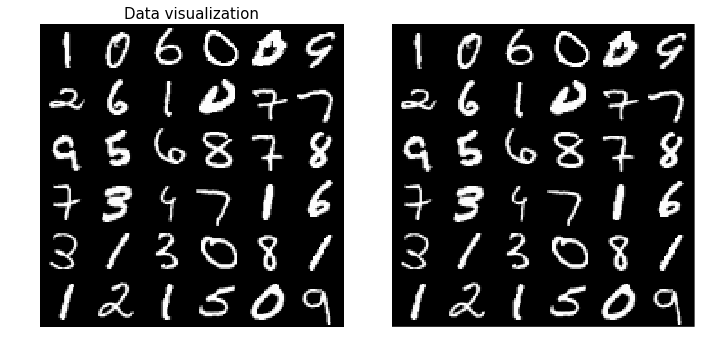

[[ 1.  0.  6.  0.  0.  9.]
 [ 2.  6.  1.  0.  7.  7.]
 [ 9.  5.  6.  8.  7.  8.]
 [ 7.  3.  4.  7.  1.  6.]
 [ 3.  1.  3.  0.  8.  1.]
 [ 1.  2.  1.  5.  0.  9.]]


In [35]:
### VISUALIZE 
canv, lab = tls.plot_svhn(x_trai, t_trai, t=6, IMG_LEN=IMG_LEN, 
                          IMG_DEPTH=IMG_DEPTH, cmap=cmap)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(canv, cmap=cmap, interpolation='nearest')
ax[1].imshow(canv, cmap=cmap, interpolation='None')

ax[0].set_title('Data visualization')
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout()
plt.show()

print(lab)
# tls.plot_svhn(x_trai, t_trai, t=6, IMG_LEN=IMG_LEN, IMG_DEPTH=IMG_DEPTH,
#                    gray=True)
    # If you get all black, consider changing 

In [8]:
### HYPER PARAMETERS
# VOLATILE HP
learning_rate = 1e-5
L1 = 0
L2 = 0

samples_to_process = 1e7
val_interval       = 1e4
batch_size         = 1e2

if not val_interval/batch_size % 1 == 0:
    print('WARNING: val_interval must be divisible by batch_size')
    print('No validation will be performed with current settings')


# ARCHITECTURE
num_latent_1 = num_classes*50
hid_size = 1000


# STABLE HP
eq_size = 1
iw_size = 1


In [9]:
### HELPER FUNCTIONS
from lasagne.objectives import squared_error

# c = -0.5 * np.log(2*np.pi)
clip = lambda x: T.clip(x,-10,10) #used to limit the variance (why?)

def log_bernoulli(x, p, eps=1e-7):
    """
    Computes the binary cross-entropy between a target and 

    Use eps if you don't want to alow values ==0, ==1
    """

    p = T.clip(p, eps, 1.0 - eps)
    return -T.nnet.binary_crossentropy(p, x)



def kl_normal_2_stdnormal(mu, lv):
    """Compute the KL divergence from the standard normal dist"""
    return - 0.5 * (1 + lv - mu**2 - T.exp(lv))


def LogLikelihood(mux, x, muq, lvq):
    """
    Compute the mean const of a set of examples
    """
    #Sum over the latent dimension, mean over the the samples
    reconstruction_cost = log_bernoulli(x, mux).sum(axis=1).mean()
    KL_qp = kl_normal_2_stdnormal(muq, lvq).sum(axis=1).mean()
        
    LL = (reconstruction_cost- KL_qp)/(IMG_LEN*IMG_LEN) 
#     print('{:10.0f}:{:10.0f}:{:10.0f}'.format(LL, reconstruction_cost, KL_qp))
    print('{}:{}:{}'.format(LL, reconstruction_cost, KL_qp))
    
    return LL, reconstruction_cost, KL_qp
    

In [10]:
%%time
### CREATE MODEL
from lasagne.nonlinearities import leaky_rectify, rectify, sigmoid
from parmesan.layers import SampleLayer


### ENCODER
l_in_x   = L.InputLayer(shape=(None, num_features), name='l_in_x')
l_in_norm= L.BatchNormLayer(l_in_x)

l_en_1   = L.DenseLayer(l_in_norm, 
                        num_units=hid_size,
                        nonlinearity=rectify,
                        name='l_en_1')
# l_en_2   = L.DenseLayer(l_en_1,
#                         num_units=hid_size,
#                         nonlinearity=rectify,
#                         name='l_en_2')

### Create latent parameters
l_mu_1   = L.DenseLayer(l_en_1,
                        num_units=num_latent_1,
                        nonlinearity=None,
                        name='l_mu_1')
l_lv_1   = L.DenseLayer(l_en_1,
                        num_units=num_latent_1,
                        nonlinearity=clip,
                        name='l_lv_1')

### sample a latent representation:
#    z ~ q(z|x) = N(mu(x), logvar(x)
l_z_1      = SampleLayer(mean=l_mu_1, 
                         log_var=l_lv_1, 
                         eq_samples=eq_size, 
                         iw_samples=iw_size, 
                         name='l_z_1')

### DECODER
l_in_z   = L.InputLayer(shape=(None, num_latent_1), 
                        name = 'l_in_z')
l_dec_1  = L.DenseLayer(l_in_z, 
                        num_units = hid_size,
                        nonlinearity = rectify,
                        name = 'l_dec_1')
# l_dec_2  = L.DenseLayer(l_dec_1, 
#                         num_units = hid_size,
#                         nonlinearity = rectify,
#                        name='l_dec_2')

# Sigmoid is used because the original images are $\in [0,1]$
l_out    = L.DenseLayer(l_dec_1, 
                        num_units=num_features,
                        nonlinearity=sigmoid,
                        name='l_out')

Wall time: 108 ms


In [11]:
# %%time
### CREATE INTERFACE VARIABLES

sym_x = T.matrix('x') # (batch_size x 3072)
sym_z = T.matrix('z') # Latent variable (batch_size x num_latent)

# Training variables
z_train, mu_train, lv_train = L.get_output([l_z_1, l_mu_1, l_lv_1],
                                           {l_in_x:sym_x}, 
                                           deterministic = False)
out_train                   = L.get_output(l_out,
                                           {l_in_z:z_train}, 
                                           deterministic = False)

# Test variables
z_eval, mu_eval, lv_eval    = L.get_output([l_z_1, l_mu_1, l_lv_1],
                                           {l_in_x:sym_x},
                                           deterministic = True)
out_eval                    = L.get_output(l_out,
                                           {l_in_z:z_eval}, 
                                           deterministic = True)

# For generating artificial data (samples)
mux_sample               = L.get_output(l_out, {l_in_z: sym_z})

# Copute the cost
LL_train, log_px_train, KL_train = \
    LogLikelihood(out_train, sym_x, mu_train, lv_train)

LL_eval, log_px_eval, KL_eval = \
    LogLikelihood(out_eval, sym_x, mu_eval, lv_eval)



Elemwise{true_div,no_inplace}.0:mean:mean
Elemwise{true_div,no_inplace}.0:mean:mean


In [12]:
# %%time
### CREATE TRAINING FUNCTIONS

all_params = L.get_all_params([l_z_1, l_out], trainable=True)
all_grads  = T.grad(-LL_train, all_params)

updates    = lasagne.updates.adam(all_grads, all_params,
                                  learning_rate=learning_rate)

# Training function: Return loss, and update weights
f_train = theano.function(inputs=[sym_x],
                          outputs=[LL_train, log_px_train, KL_train],
                          updates=updates)

# Evaluation function: Return loss
f_eval = theano.function(inputs=[sym_x],
                         outputs=[LL_train, log_px_train, KL_train])

# Get latent variable values
f_z              = theano.function(inputs=[sym_x], outputs=[z_eval])

# Return the reconstruction
f_reconstruction = theano.function(inputs=[sym_x], outputs=[out_eval])

# Simulate artificial data, given an artificial latent variable
f_simulate = theano.function(inputs=[sym_z], outputs=[mux_sample])


KeyboardInterrupt: 

In [ ]:
# %%time
### TRAINING
from IPython.display import Image, display, clear_output
import sklearn.decomposition
pca = sklearn.decomposition.PCA(n_components=2)



LL_train, KL_train, logpx_train = [],[],[]
LL_valid, KL_valid, logpx_valid = [],[],[]
samples_processed = 0

valid_samples_processed = []


try:
    while samples_processed < samples_to_process:
#         _LL_train, _KL_train, _logpx_train = [],[],[]
        idxs = np.random.choice(
                range(x_trai.shape[0]), 
                size=(batch_size), 
                replace=False)
    
        out = f_train(x_trai[idxs])
        samples_processed += batch_size
            
        if samples_processed % val_interval == 0:
            print('{:10.0f} sampeles processed.'.format(samples_processed))
            print('{:10.0f} sampeles in total.'.format(samples_to_process))
            valid_samples_processed += [samples_processed]

            # Run through training set
            out = f_eval(x_trai[:10000]) # TAKES A LOT OF MEMORY!
            LL_train    += [out[0]]
            logpx_train += [out[1]]
            KL_train    += [out[2]]
            
            # Run through validation set
            out = f_eval(x_vali)
            LL_valid    += [out[0]]
            logpx_valid += [out[1]]
            KL_valid    += [out[2]]
            
            # Compute latent variables
            z_eval = f_z(x_vali)[0]
            
            # Create samples, sampling from prior distribution (std. normal)
            x_sample = f_simulate(np.random.normal(size=(100, num_latent_1)).astype('float32'))[0]
#             x_sample = f_sample(np.random.normal(size=(100, num_latent_1 * size_up_factor)).astype('float32'))[0]

            
            # Create reconstruction
            x_recon = f_reconstruction(x_vali)[0]

            
            
            
            if plot_train:
#             if False:
                plt.subplots(figsize=(7, 7), dpi=50)

                ### Plot learning curves 
                plt.subplot(num_classes+2,2,1)
                plt.xlabel('Updates')
                plt.plot(valid_samples_processed, LL_train, 
                         color="black", label='LL')
                plt.plot(valid_samples_processed, logpx_train, 
                         color="red", label='log(p(x))')
                plt.plot(valid_samples_processed, LL_valid, 
                         color="black", 
                         linestyle="--")
                plt.plot(valid_samples_processed, logpx_valid,
                         color="red", 
                         linestyle="--")
                plt.legend(loc=2)
                plt.title('-train, --valid')
                plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
                plt.grid('on')
                
                ### Plot PCA of latent space
                plt.subplot(num_classes+2,2,2)
                plt.cla()
                plt.xlabel('PCA 0'), plt.ylabel('PCA 1')
                color = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, num_classes)))
                for i in range(num_classes):
                    clr = next(color)
                    pca_trans = pca.fit_transform(z_eval)
                    plt.scatter(pca_trans[tls.onehot2int(t_vali)==i, 0], 
                                pca_trans[tls.onehot2int(t_vali)==i, 1], 
                                c=clr, 
                                s=5., 
                                lw=0, 
                                marker='o', )
                plt.grid('on')

#                 plt.savefig("out52.png")
#                 display(Image(filename="out52.png"))

                ### PLOT KL term
                plt.subplot(num_classes+2,2,3)
                plt.legend(['KL(q||p)'])
                plt.xlabel('Updates')
                plt.plot(valid_samples_processed, KL_train, color="blue")
                plt.plot(valid_samples_processed, KL_valid, color="blue", linestyle="--")
                plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

                # Formatting
                plt.grid('on')
                plt.tight_layout()
                
                
                
                
                ### Plot samples                
                sample, _ = tls.plot_svhn(x_sample, t=6, cmap=cmap,
                    IMG_LEN=IMG_LEN, IMG_DEPTH=IMG_DEPTH)

                
                ## PLOT images and their reconstructions
                orig_all = []
                recon_all= []
                for c in range(num_classes):
                    orig, _ = tls.plot_svhn(x_vali[tls.onehot2int(t_vali)==c], 
                                             t=6, cmap=cmap, IMG_LEN=IMG_LEN, 
                                             IMG_DEPTH=IMG_DEPTH)
                    orig_all.append(orig)

                    recon, _ = tls.plot_svhn(x_recon[tls.onehot2int(t_vali)==c],
                                             t=6, cmap=cmap, IMG_LEN=IMG_LEN, 
                                             IMG_DEPTH=IMG_DEPTH)
                    recon_all.append(recon)
        
        
            # Clear previous plots
            clear_output(wait=True)

            plt.imshow(sample, cmap=cmap, interpolation='None')
            plt.title('Samples')
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            
            for c in range(num_classes):
                _, ax = plt.subplots(1,2)

                ax[0].imshow(orig_all[c], cmap=cmap, interpolation='None')
                ax[0].set_title('Original')
                ax[0].axis('off')
                
                ax[1].imshow(recon_all[c], cmap=cmap, interpolation='None')
                ax[1].set_title('Reconstruction')
                ax[1].axis('off')

                plt.tight_layout()
                plt.show()
                
        
except KeyboardInterrupt:
    pass

print('Training complete')

In [ ]:
x_sample = f_simulate(np.random.normal(size=(100, num_latent_1)).astype('float32'))[0]

print(x_sample.shape)
# print(x_sample[0])
print(max(x_sample[0]))



canv, _ = tls.plot_svhn(x_sample, t=6, cmap=cmap,
    IMG_LEN=IMG_LEN, IMG_DEPTH=IMG_DEPTH)

plt.imshow(canv, cmap=cmap)
plt.show()



In [ ]:
# fig, ax_sam = plt.subplots()

# x_sample.shape

# ax_sam.cla()
# plt.title('Samples')
# plt.axis('off')



# idx = 0
# canvas = np.zeros((IMG_LEN*10, 10*IMG_LEN, ))
# ## Plot generated samples
# for i in range(10):
#     for j in range(10):
#         if dataset == 'SVHN':
#             canvas[i*IMG_LEN:(i+1)*IMG_LEN, j*IMG_LEN:(j+1)*IMG_LEN, :] = \
#                 x_sample[idx].reshape((IMG_LEN, IMG_LEN, 3))
#         elif dataset == 'MNIST':
#             canvas[i*IMG_LEN:(i+1)*IMG_LEN, j*IMG_LEN:(j+1)*IMG_LEN] = \
#                 x_sample[idx].reshape((IMG_LEN, IMG_LEN))                            
#         idx += 1
# plt.imshow(canvas)
# plt.tight_layout()
